<a href="https://colab.research.google.com/github/arnoldjames98/arnoldjames98.github.io/blob/main/systemKinematics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Biodegradable Crab Leg Mechanism](https://arnoldjames98.github.io/)
# System Kinematics

### 1. Create a figure of your system kinematics.

We decided to create two figures. The first shows the reference frames and cooresponding state variables used to represent the mechanism. The second shows all the geometric constraints of the mechanism and is followed by a table with the relevant information.

![Mechanism Drawing - Lengths](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/assignment3/frames.png) 

![Mechanism Drawing - Frames](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/assignment3/lengths.png)

| Length | Rigid Body | Measurement (cm)
| --- | --- | --- |
| L10 | Yellow | 3 |
| L02 | Purple | 6.89 |
| L42 | Purple | 9.73 |
| L40 | Purple | 7.37 |
| L31 | Red | 6.6 |
| L61 | Red | 12.36 | 
| L63 | Red | 5.84 |
| L54 | Green | 5.79 |
| L32 | Orange | 3.59 |
| L56 | Blue | 10.04 |
| L5E | Blue | 19.40 |
| LE6 | Blue | 10.04 |


### 2. Make the device in paper or cardboard. You need an up-to-date model if it has changed from your individual assignments. The paper model should dimensionally match your code.

A prototype of the mechansim using foldable joints was created based on the dimensions from the table in the previous section. Note that two layers are required to prevent interference in the foldable mechanism.
![Mechanism Drawing](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/assignment3/CardboardPaper1.1.jpg)
![Mechanism Drawing](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/assignment3/CardboardPaper2.1.jpg)

### 3. Using a pynamics-based script, develop a kinematic model for your device.

Show plots inline and ensure that pynamics is installed.

In [ ]:
%matplotlib inline
!pip install pynamics

Import all required packages. Packages related to dynamics are commented out since they are not needed for this assignment, but will be used in the future.

In [ ]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
#from pynamics.body import Body
#from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
#from pynamics.particle import Particle
import pynamics.integration
import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
#from pynamics.constraint import Constraint
import scipy.optimize

Create a pynamics system where the mechanism is located.

In [ ]:
system = System()
pynamics.set_system(__name__,system)

Declare all length constants.

In [ ]:
# From Loop Closure Eq. #1
l_10 = Constant(3,'l_10',system)
l_31 = Constant(6.6,'l_31',system)
l_32 = Constant(3.59,'l_32',system)
l_02 = Constant(6.8877,'l_02',system)

# From Loop Closure Eq. #2
#l_10 already is included in Eq. 1
l_61 = Constant(12.363,'l_61',system)
l_56 = Constant(10.04,'l_56',system)
l_54 = Constant(5.79,'l_54',system)
l_40 = Constant(7.3736,'l_54',system)

# From Loop Closure Eq. #3
#l_32 already is included in Eq. 1
#l_54 already is included in Eq. 2
#l_56 already is included in Eq. 2
l_63 = Constant(5.84,'l_63',system)
l_42 = Constant(9.73,'l_42',system)

# End effector
l_E6 = Constant(10.04,'l_E6',system)
l_5E = Constant(19.396,'l_5E',system)

# Consider adding the constant angle constraints in the future

Create the differentiable state variables, cooresponding to the joint angles (we might not need all of these depending on how we do the constraints)

In [ ]:
# Note: All angles are measured CCW

# Input state variable (angle of crank on yellow link)
qY,qY_d,qY_dd = Differentiable('qY',system) # Yellow input link, measured from base frame coordinates

# Other state variables (angles of the four undefined links)
# Note that the purple link is ground so is fully defined
qO,qO_d,qO_dd = Differentiable('qO',system) # Orange link w.r.t base frame
qG,qG_d,qG_dd = Differentiable('qG',system) # Green link w.r.t base frame

# Links defined w.r.t non-ground link (not connected to ground)
qR,qR_d,qR_dd = Differentiable('qR',system) # Red link w.r.t yellow link frame
qB,qB_d,qB_dd = Differentiable('qB',system) # Blue link w.r.t green link frame

Initial guess for starting positions

In [ ]:
# TODO: We can measure the angles on our directly from our figure to make some guesses
initialvalues = {}
# Yellow link w.r.t base
initialvalues[qY]=130*pi/180 #130*pi/180 (positive) is the input for which I estimated the other angles
initialvalues[qY_d]=0

# Orange link w.r.t base (measure angle from the standard horizontal x-axis, the shape of the purple ground link is not needed here)
initialvalues[qO]=130*pi/180
initialvalues[qO_d]=0

# Green link w.r.t base (measure angle from the standard horizontal x-axis, the shape of the purple ground link is not needed here)
initialvalues[qG]=160*pi/180
initialvalues[qG_d]=0

# Red link w.r.t yellow link frame
initialvalues[qR]=30*pi/180
initialvalues[qR_d]=0

# Blue link w.r.t green link frame
initialvalues[qB]=60*pi/180
initialvalues[qB_d]=0

Retrieve state variables in the order they are stored in the system

In [ ]:
# Not sure if we need this, but it's included in the tutorial
statevariables = system.get_state_variables()

Create the main reference frames, with one cooresponding to each rigid link
**Need to update the figure in this notebook, for now refer to first slide of google slides**

In [ ]:
N = Frame('N') # Purple (ground) link

# Defined w.r.t to ground
Y = Frame('Y') # Yellow
O = Frame('O') # Orange
G = Frame('G') # Green

# Defined w.r.t to other links 
# Note that both are directed towards p6
# Important since this is how the angle representing the link is defined
R = Frame('R') # Red w.r.t yellow
B = Frame('B') # Blue w.r.t green

# Helpful additional frames for triangular links
# These frames define the constant angles within the triangular joints
R_to_p3 = Frame('R_to_p3') # Red w.r.t yellow (+ constant degrees to align x-axis with p3)
B_to_pE = Frame('B_to_pE') # Blue w.r.t green (+ constant degrees to align x-axis with pE)
B_plus_180 = Frame('B_plus_180') # Blue with x axis in opposite direction
R_from_p3 = Frame('R_from_p3') # Red rotated so that it can point from p3 to p6 (CW rotation)
B_from_p6 = Frame('B_from_p6') # Blue rotated so it can go from p6 to pE

Declare N as the Newtonian (fixed) frame

In [ ]:
system.set_newtonian(N)

Rotate frames about their z-axes so they align with the correct rigid link.

In [ ]:
# Frames cooresponding to joint angles
Y.rotate_fixed_axis_directed(N,[0,0,1],qY,system) # Yellow
O.rotate_fixed_axis_directed(N,[0,0,1],qO,system) # Orange
G.rotate_fixed_axis_directed(N,[0,0,1],qG,system) # Green
R.rotate_fixed_axis_directed(Y,[0,0,1],qR,system) # Red w.r.t yellow
B.rotate_fixed_axis_directed(G,[0,0,1],qB,system) # Blue w.r.t green

# Helpful frames for triangular joints
# 6.007 degrees from B frame to align axis with p3
R_to_p3.rotate_fixed_axis_directed(Y,[0,0,1],qR+6.007*pi/180,system) # Red w.r.t yellow
# 15 degrees from B frame to align axis with pE
B_to_pE.rotate_fixed_axis_directed(G,[0,0,1],qB+15*pi/180,system) # Blue w.r.t green
# B plus 180 (this comes in handy later when defining a vector in the opposite direction)
B_plus_180.rotate_fixed_axis_directed(G,[0,0,1],qB+180*pi/180,system) # Blue reversed
# R - 5.84 degrees (CW rotation) from p3 to p6
R_from_p3.rotate_fixed_axis_directed(Y,[0,0,1],qR-12.8*pi/180,system) # Red w.r.t yellow
# Rotate B frame 30 degrees CCW to go from p6 to pE
B_from_p6.rotate_fixed_axis_directed(G,[0,0,1],qB+30*pi/180,system)

Define vectors for each of the joint locations.
*Note: Not all vectors here are necessary for the chosen loop closure equations, but are kept here since they could be useful in future assignments.*

In [ ]:
# Vectors representing the joint locations w.r.t N frame
# Fixed points on pruple (ground) link
p0 = 0*N.x # P0 is at the origin (shifted by -10, -10 units from figure we are basing our units off of)
p2 = -6.6*N.x - 1.97*N.y # Coordinates given
p4 = -2.6*N.x + 6.9*N.y # Coordinates given

# Note that for all other points, they are still w.r.t N frame, but they can be defined from different directions/pathways
# Defining the same point from different directions/pathways is needed for constraints
# Points directly connected to ground
p1_from_p0 = p0 + l_10*Y.x
p3_from_p2 = p2 + l_32*O.x
p5_from_p4 = p4 + l_54*G.x

# Additional points (Consider alternative defnitions of these)
p6_from_p1 = p1_from_p0 + l_61*R.x
pE_from_p5 = p5_from_p4 + l_5E*B_to_pE.x # 15 degrees CCW from B frame x axis

# Alternate pathways to points (used to make LHS and RHS of loop equations defined differently)
p3_from_p1 = p1_from_p0 + l_31*R_to_p3.x # 6.007 degrees (CCW) from R frame x axis
p5_from_p6 = p6_from_p1 + l_56*B_plus_180.x # 180 degress (CCW) from B frame x axis
p6_from_p3 = p3_from_p2 + l_63*R_from_p3.x # -5.84 degress (CW) from R frame x axis
pE_from_p6 = p6_from_p3 + l_E6*B_from_p6.x

# List of points to that will be used for plotting 
# Doesn't matter which version of points like p1 we use since they will be constrained to be equal
points = [p0, p1_from_p0, p2, p3_from_p2, p4, p5_from_p4, p6_from_p1, pE_from_p6]

Create a list of initial values ini0 in the order of the system’s state variables

In [ ]:
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

Create all the vector equation constraints (e.g., loop closure equations, rigid link constraints, etc.)

We indentified that two loop closure equations that will be used to constrain the system. 

![Loop Closure Equation 1](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/assignment3/eq1.png)
![Loop Closure Equation 2](https://raw.githubusercontent.com/arnoldjames98/arnoldjames98.github.io/main/images/assignment3/eq2.png)

In [ ]:
# Loop closure equations (constraint to ensure all loops are equal to zero)
# Equation 1 (R02 + R10 + R31 = R32)
loopClosure1 = p3_from_p1 - p3_from_p2
#print("p3_from_p2:", p3_from_p2)
#print("p3_from_p1:", p3_from_p1)
#print("loopClosure1", loopClosure1)

# Equation 2 (R10 + R61 + R56 = R40 + R54)
loopClosure2 = p5_from_p4 - p5_from_p6
#print("p5_from_p4:", p5_from_p4)
#print("p5_from_p6:", p5_from_p6)
#print("loopClosure2", loopClosure2)

Convert the vector constraints into scalar equations that can be solved

In [ ]:
eq = [] # Initialize

# Loop closure equations
eq.append((loopClosure1).dot(N.x))
eq.append((loopClosure1).dot(N.y))

eq.append((loopClosure2).dot(N.x))
eq.append((loopClosure2).dot(N.y))

# Show the equations
print(eq)

# Take the derivatives
eq_d=[(system.derivative(item)) for item in eq]

# Show the derivatives
print(eq_d)

[l_10*cos(qY) - l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299) - l_32*cos(qO) + 6.6, l_10*sin(qY) + l_31*sin(qY)*cos(qR + 0.104841928167299) + l_31*sin(qR + 0.104841928167299)*cos(qY) - l_32*sin(qO) + 1.97, -l_10*cos(qY) + l_54*cos(qG) + l_56*sin(qG)*sin(qB + 3.14159265358979) - l_56*cos(qG)*cos(qB + 3.14159265358979) + l_61*sin(qR)*sin(qY) - l_61*cos(qR)*cos(qY) - 2.6, -l_10*sin(qY) + l_54*sin(qG) - l_56*sin(qG)*cos(qB + 3.14159265358979) - l_56*sin(qB + 3.14159265358979)*cos(qG) - l_61*sin(qR)*cos(qY) - l_61*sin(qY)*cos(qR) + 6.9]
[l_32*qO_d*sin(qO) + qR_d*(-l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY)) + qY_d*(-l_10*sin(qY) - l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY)), -l_32*qO_d*cos(qO) + qR_d*(-l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299)) + qY_d*(l_10*cos(qY) - l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 

identify independent and dependent variables

In [ ]:
qi = [qY] # Yellow link is the input
qd = [qO, qG, qR, qB] # All other links are dependent on the input

For dependent variables, create an initial guess and create a copy of symbolic constants dictionary and add the initial value of qi to it

In [ ]:
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

Substitute constants in equation

In [ ]:
eq = [item.subs(constants) for item in eq]
print(eq)

[-5.05589332458525*sin(qR + 0.104841928167299) - 3.59*cos(qO) - 4.24239822393116*cos(qR + 0.104841928167299) + 4.67163717094038, -3.59*sin(qO) - 4.24239822393116*sin(qR + 0.104841928167299) + 5.05589332458525*cos(qR + 0.104841928167299) + 4.26813332935693, 10.04*sin(qG)*sin(qB + 3.14159265358979) + 9.47060745027992*sin(qR) - 10.04*cos(qG)*cos(qB + 3.14159265358979) + 7.3736*cos(qG) + 7.94678321855469*cos(qR) - 0.671637170940382, -10.04*sin(qG)*cos(qB + 3.14159265358979) + 7.3736*sin(qG) + 7.94678321855469*sin(qR) - 10.04*sin(qB + 3.14159265358979)*cos(qG) - 9.47060745027992*cos(qR) + 4.60186667064307]


convert to numpy array

sum the error

In [ ]:
error = (numpy.array(eq)**2).sum()


### 4. Select or solve for a valid initial condition that represents the system in the middle of a typical gait, when it is both moving and when forces are being applied to it (or to the world by it)

Convert to a function that scipy can use. Sympy has a “labmdify” function that evaluates an expression, but scipy needs a slightly different format.

In [ ]:
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

Take the derivative of the equations to linearize with regard to the velocity variables

In [ ]:
guess = [initialvalues[item] for item in qd]

result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
print("Tolerance:", result.fun)

ini = []

for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]))

2021-02-20 06:34:39,882 - pynamics.output - INFO - calculating outputs
2021-02-20 06:34:39,884 - pynamics.output - INFO - done calculating outputs


Tolerance: 1.8692749976283435e-13


array([[[  0.        ,   0.        ],
        [ -1.92836283,   2.29813333],
        [ -6.6       ,  -1.97      ],
        [ -8.90760752,   0.78009955],
        [ -2.6       ,   6.9       ],
        [ -9.52891751,   9.42191973],
        [-13.5457827 ,   6.52652836],
        [-17.25039872,  -5.49083841]],

       [[  0.        ,   0.        ],
        [ -1.92836283,   2.29813333],
        [ -6.6       ,  -1.97      ],
        [ -8.42286323,   1.12277701],
        [ -2.6       ,   6.9       ],
        [ -9.25061921,  10.0842175 ],
        [-14.25734781,   1.38167361],
        [-14.18266071,  -8.04908442]]])

### 5. Plot the system in this position.

Create a plot of the optimized points defining the mechanism.

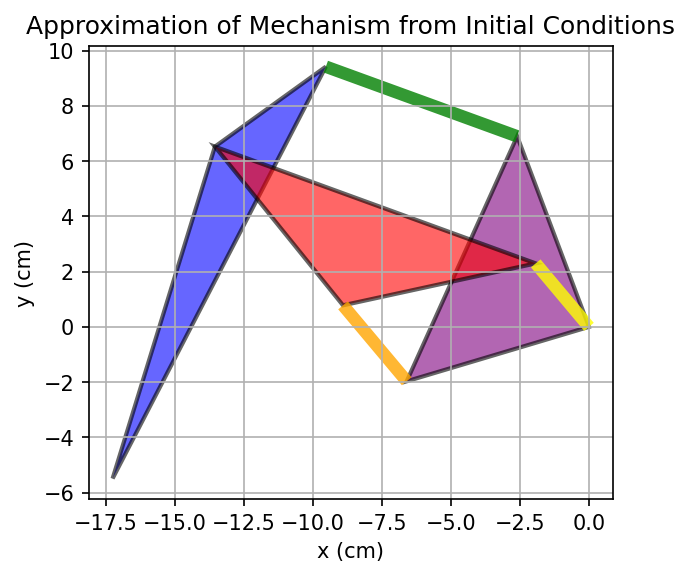

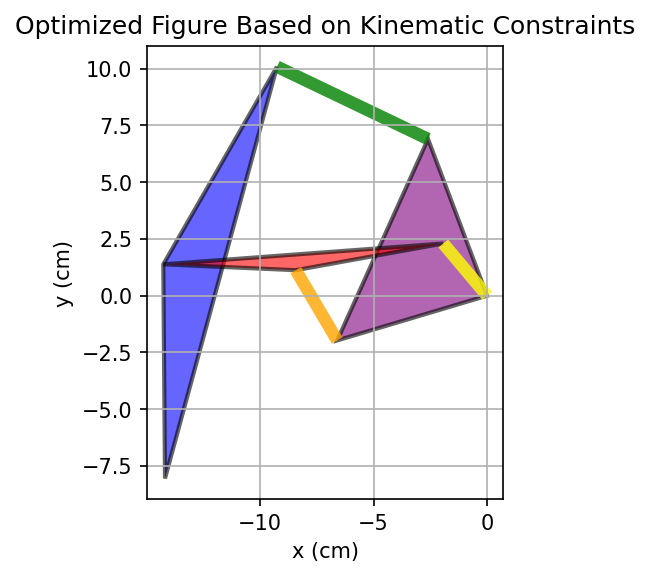

In [ ]:
# Figure when inputting the guesses for intial joint angles
plt.figure(dpi=150)
# Blue link
plt.fill([points.y[0][7,0], points.y[0][6,0], points.y[0][5,0]], [points.y[0][7,1], points.y[0][6,1], points.y[0][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
# Purple link
plt.fill([points.y[0][0,0], points.y[0][2,0], points.y[0][4,0]], [points.y[0][0,1], points.y[0][2,1], points.y[0][4,1]], facecolor='purple', edgecolor="black",linewidth=2, alpha=0.6)
# Red link
plt.fill([points.y[0][1,0], points.y[0][3,0], points.y[0][6,0]], [points.y[0][1,1], points.y[0][3,1], points.y[0][6,1]], facecolor='red', edgecolor="black",linewidth=2, alpha=0.6)
# Orange link
plt.fill([points.y[0][2,0], points.y[0][3,0]], [points.y[0][2,1], points.y[0][3,1]], edgecolor="orange",linewidth=6, alpha=0.8)
# Green link
plt.fill([points.y[0][4,0], points.y[0][5,0]], [points.y[0][4,1], points.y[0][5,1]], edgecolor="green",linewidth=6, alpha=0.8)
# Yello link
plt.fill([points.y[0][0,0], points.y[0][1,0]], [points.y[0][0,1], points.y[0][1,1]], edgecolor="yellow",linewidth=6, alpha=0.8)

# Make the plot readable
plt.title('Approximation of Mechanism from Initial Conditions')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')

plt.grid()
plt.axis('scaled')
plt.show()


# Figure for the correct joint angles optimized from the guessed initial conditions
plt.figure(dpi=150)
# Blue link
plt.fill([points.y[1][7,0], points.y[1][6,0], points.y[1][5,0]], [points.y[1][7,1], points.y[1][6,1], points.y[1][5,1]], facecolor='blue', edgecolor="black",linewidth=2, alpha=0.6)
# Purple link
plt.fill([points.y[1][0,0], points.y[1][2,0], points.y[1][4,0]], [points.y[1][0,1], points.y[1][2,1], points.y[1][4,1]], facecolor='purple', edgecolor="black",linewidth=2, alpha=0.6)
# Red link
plt.fill([points.y[1][1,0], points.y[1][3,0], points.y[1][6,0]], [points.y[1][1,1], points.y[1][3,1], points.y[1][6,1]], facecolor='red', edgecolor="black",linewidth=2, alpha=0.6)
# Orange link
plt.fill([points.y[1][2,0], points.y[1][3,0]], [points.y[1][2,1], points.y[1][3,1]], edgecolor="orange",linewidth=6, alpha=0.8)
# Green link
plt.fill([points.y[1][4,0], points.y[1][5,0]], [points.y[1][4,1], points.y[1][5,1]], edgecolor="green",linewidth=6, alpha=0.8)
# Yello link
plt.fill([points.y[1][0,0], points.y[1][1,0]], [points.y[1][0,1], points.y[1][1,1]], edgecolor="yellow",linewidth=6, alpha=0.8)

plt.title('Optimized Figure Based on Kinematic Constraints')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.grid()
plt.axis('scaled')
plt.show()

#### 3.6-7 Create the Jacobian

Turn constraint equations into a vector

In [ ]:
eq_d = sympy.Matrix(eq_d)
print(eq_d)

Matrix([[l_32*qO_d*sin(qO) + qR_d*(-l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY)) + qY_d*(-l_10*sin(qY) - l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY))], [-l_32*qO_d*cos(qO) + qR_d*(-l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299)) + qY_d*(l_10*cos(qY) - l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299))], [qB_d*(l_56*sin(qG)*cos(qB + 3.14159265358979) + l_56*sin(qB + 3.14159265358979)*cos(qG)) + qG_d*(-l_54*sin(qG) + l_56*sin(qG)*cos(qB + 3.14159265358979) + l_56*sin(qB + 3.14159265358979)*cos(qG)) + qR_d*(l_61*sin(qR)*cos(qY) + l_61*sin(qY)*cos(qR)) + qY_d*(l_10*sin(qY) + l_61*sin(qR)*cos(qY) + l_61*sin(qY)*cos(qR))], [qB_d*(l_56*sin(qG)*sin(qB + 3.14159265358979) - l_56*cos(qG)*cos(qB + 3.14159265358979)) + qG_d*(l_54*cos(qG) + l_56*sin(qG)*sin(qB + 3.14159265358979) - l_56*cos(qG)*cos(qB + 3.14159265358979)) + qR_d*(l_61*sin(qR)*sin(qY)

Turn qi and qd into sympy vectors

In [ ]:
qi = sympy.Matrix([qY_d])
qd = sympy.Matrix([qO_d,qG_d,qR_d,qB_d])

take partial derivative of constraints with respect to independent and dependent variables:

In [ ]:
AA = eq_d.jacobian(qi)
BB = eq_d.jacobian(qd)

Solve for internal input/output Jacobian

In [ ]:
J = -BB.inv()*AA
print(J)

Matrix([[-(-l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299))*(-l_10*sin(qY) - l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY))/(l_32*(-l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299))*sin(qO) + l_32*(-l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY))*cos(qO)) + (-l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY))*(l_10*cos(qY) - l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299))/(l_32*(-l_31*sin(qY)*sin(qR + 0.104841928167299) + l_31*cos(qY)*cos(qR + 0.104841928167299))*sin(qO) + l_32*(-l_31*sin(qY)*cos(qR + 0.104841928167299) - l_31*sin(qR + 0.104841928167299)*cos(qY))*cos(qO))], [-(((l_56*sin(qG)*sin(qB + 3.14159265358979) - l_56*cos(qG)*cos(qB + 3.14159265358979))*(-l_54*sin(qG) + l_56*sin(qG)*cos(qB + 3.14159265358979) + l_56*sin(qB + 3.14159265358979)*cos(qG)) - (l_56*sin(q

### 6. From your biomechanics-based specifications, define one or more force vector estimates (one for each end effector) that the system should be expected to experience. Consider including, based on your research



*   the force of gravity exerted by the mass of a “payload” or the main body of the robot.
*   the acceleration the system experiences during a typical gait
*   ground reaction forces measured from biomechanics studies.




The force of gravity excerted by the main body of the robot is going to be less than 0.94 N depending on the size of the ghost crab. The acceleration the system experiences is usually around 3.12 m/s^2. The ground reaction forces are around the values 0.234 N.

### 7. Calculate the force or torque required at the input to satisfy the end-effector force requirements

In [ ]:
# The state variables (qY, qO, qG, qR, qB) from the optimized plot
#print(ini[0:5])
from sympy import lambdify

# Inputs to the Jacobian
configuration = (qY, qO, qG, qR, qB)

# A function representing the Jacobian with state variables as inputs
J_func = lambdify(configuration, J.subs(system.constant_values), modules='numpy')

# Input the state variables for the current conditions
J_specific = J_func(*ini[0:5])

# Show the specific J for the given state variables and constant lengths
#J_specific

# Using reaction force and converting to torque at q_B
perpDistance = (points.y[1][7,0] - points.y[1][5,0])*0.01
torque_b = (0.234)*(perpDistance)

# Create a vector representing the torque felt at the B frame joint
torqueVector = numpy.array([0,0,0,torque_b])

# Flatten the array so a dot product can be taken easily
J_specific_flat = J_specific.flatten()

# Finally, calculate the required torque at the input
inputTorque = J_specific_flat.dot(torqueVector)
print("Required Input Torque:", inputTorque, "N⋅m")

Required Input Torque: 0.005136119649194768 N⋅m


To calculate the torque required to satisfy the end-effector force requirements, we used the ground reaction force and multplied by its length. To find the force, we multpilied the jacobian transposed to a 4x1 vector that shows torque as its last element. The calculated force turned out to be 0.005N.m

### 8. Estimate the velocity of the end-effector in this configuration. Using the Jacobian, calculate the speed required by the input(s) to achieve that output motion.

In [ ]:
# Solving for the dependent variables qd 
# Creates an expression dependent in the state variables and the speed of the input (derivative of qY)
qd_givenInput = J*qi

# Create a dictionary to replace all the state variables
subs = dict([(ii,jj) for ii,jj in zip(qd,qd_givenInput)])

# Selecting the end effector
p_E = pE_from_p5
v_E = pE_from_p5.time_derivative()

# Substitue in the subs dictionary
v_E = v_E.subs(subs)

# Pull the x and y components of the end effector speed in the N frame
# Then, you just need qY_d (speed of input) and state variables (based on the configuration) to get the velocity of the end effector
vx_E = v_E.dot(N.x)
vy_E = v_E.dot(N.y)

Now an estimates of `vx_E` and `vy_E` is needed in order to solve for the speed of the input: `qY_d`.
From the biomechanics assignment

In [ ]:
vx_E_estimated = 0 # 
vy_E_estimated = 28.39 # 

# Now, need vx_E and vy_E to only be functions of qY_d
vx_E_subs = vx_E.subs(system.constant_values)
vy_E_subs = vy_E.subs(system.constant_values)

# Now, we have experessions that are only functions of the speed of the input
vx_E_subs2 = vx_E_subs.subs({qY:ini[0], qO:ini[1], qG:ini[2], qR:ini[3], qB:ini[4]})
print(vx_E_subs2)
vy_E_subs2 = vy_E_subs.subs({qY:ini[0], qO:ini[1], qG:ini[2], qR:ini[3], qB:ini[4]})
print(vy_E_subs2)

# Pull the factor being multiplied by qY_d
qY_d_factor1 = float(vx_E_subs2.subs({qY_d :1}))
qY_d_factor2 = float(vy_E_subs2.subs({qY_d :1}))

# Using only the y term since it is assumed that the velocity primarily downwards the moment the leg hits the ground
qY_d_found = vy_E_estimated / qY_d_factor2

-4.10744777237637*qY_d
-0.946608595070641*qY_d


### 9. Finally, using the two estimates about force and speed at the input, compute the required power in this configuration.

The equations for power required at the input is P=τω. Therefore, the solutions of part 7 and 8 can be multiplied to find the power. However, the units of these values must be taken into account.

In [ ]:
P = inputTorque*qY_d_found
print("Power:", P, "W")

Power: 65.10973607390267 W




---


## Discussion

### 1. How many degrees of freedom does your device have? How many motors? If the answer is not the same, what determines the state of the remaining degrees of freedom? How did you arrive at that number?

Our device is a 1 degree of freedom (DOF) mechanism, since the location of the end-effector (and any point on the device) is completely determined by the angle value of the input. While each of the joints each have 1-DOF of rotational motion, the mechanism is designed so that the movement of the mechanism is constrained in such a way that these DOFs do not each require their own actuation to move the end-effector. Therefore, only a single motor is required control the device. As referenced throughout this assignment, the input is the rotation of the yellow link w.r.t to the base frame (denoted as qY), and the single motor will be required at this link. Since the mechanism as the same number of DOFs as motors that are required, there is no ambiguity in how the position of the end-effector will be determined.



### 2. If your mechanism has more than one degree of freedom, please describe how those multiple degrees of freedom will work together to create a locomotory gait or useful motion. What is your plan for synchonizing, especially if passive energy storage?

Since our device only has a single DOF, the locomotion of our robot will be fully determined by this DOF. The mechanism described in this assignment only represents a single leg of our crab robot, but multiple of these mechanisms can be connected to a single motor shaft at different values of qY to allow for multiple legs, each with 1 fully-defined DOF.


### 3. How did you estimate your expected end-effector forces?


From the [*Biomechanics Background and Initial Specifications*](https://arnoldjames98.github.io/assignment2) assignment, it was calculated, through a measured acceleration, that the force excerted at the end-effector is 0.234 N. This was calculated using Newton's second law which derives the equation F=ma. This equation was used to convert the end-effector acceleration into the end-effector force. 


### 4. How did you estimate your expected end-effector speeds


We estimated our end effector speeds through the use of our [*Biomechanics Background and Initial Specifications*](https://arnoldjames98.github.io/assignment2) values. The stride length, speed of the crab, and mass were used to estimate the x and y values of the velocity of the mechanism at the end effector, as well as the force exerted at the end effector. Through finding the values of the forces in the x and y-direction, we were able to solve for the input speed.
